In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('indian_food.csv')
df = data.copy()

In [3]:
df.head().append(df.tail(5))

,ItemID,RestID,OrderNumber,OrderDate,OrderTime,CustLocationEasting,CustLocationNorthing,Quantity,RestaurantName,RestaurantCity,RestEasting,RestNorthing,ItemName,ProductPrice,Vegetarian,Strength,ProdTypeID,ProdType,ProdTypeName
0,427,1,94161,29/12/2019,18:51,525631,188071,1,Tendulkar Palace,London,522495,184515,Red Sauce,0.50,Y,3,1,1,Side
1,425,1,94161,29/12/2019,18:51,525631,188071,1,Tendulkar Palace,London,522495,184515,Mint Sauce,0.50,Y,0,1,1,Side
2,426,1,94161,29/12/2019,18:51,525631,188071,1,Tendulkar Palace,London,522495,184515,Onion Chutney,0.50,Y,0,1,1,Side
3,424,1,94161,29/12/2019,18:51,525631,188071,1,Tendulkar Palace,London,522495,184515,Mango Chutney,0.50,Y,1,1,1,Side
4,425,1,94157,29/12/2019,18:28,524254,185731,1,Tendulkar Palace,London,522495,184515,Mint Sauce,0.50,Y,0,1,1,Side
166914,433,2,25574,30/07/2022,19:13,396463,274802,2,Dravid Mansion,Birmingham,413980,282310,Naan,2.50,Y,1,1,1,Side
166915,507,2,25574,30/07/2022,19:13,396463,274802,1,Dravid Mansion,Birmingham,413980,282310,Bombay Aloo,5.95,Y,2,1,1,Side
166916,567,2,25574,30/07/2022,19:13,396463,274802,1,Dravid Mansion,Birmingham,413980,282310,Chicken Tikka (Main),8.95,N,2,3,3,Main
166917,570,2,25574,30/07/2022,19:13,396463,274802,2,Dravid Mansion,Birmingham,413980,282310,Chicken Tikka Jalfrezi,8.95,N,5,3,3,Main
166918,585,2,25574,30/07/2022,19:13,396463,274802,2,Dravid Mansion,Birmingham,413980,282310,Dhansak - Chicken Tikka,8.95,N,4,3,3,Main


In [4]:
df.shape

(166919, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166919 entries, 0 to 166918
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ItemID                166919 non-null  int64  
 1   RestID                166919 non-null  int64  
 2   OrderNumber           166919 non-null  int64  
 3   OrderDate             166919 non-null  object 
 4   OrderTime             166919 non-null  object 
 5   CustLocationEasting   166919 non-null  int64  
 6   CustLocationNorthing  166919 non-null  int64  
 7   Quantity              166919 non-null  int64  
 8   RestaurantName        166919 non-null  object 
 9   RestaurantCity        166919 non-null  object 
 10  RestEasting           166919 non-null  int64  
 11  RestNorthing          166919 non-null  int64  
 12  ItemName              166919 non-null  object 
 13  ProductPrice          166919 non-null  float64
 14  Vegetarian            166919 non-null  object 
 15  

## Data Preparation

### Datetime data

In [6]:
# OrderDate
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# OrderTime
df['OrderTime'] = pd.to_datetime(df['OrderTime'])

### EDA & Feature Creation

In [7]:
# Create order total price column
df['TotalPrice'] = df['ProductPrice']*df['Quantity']

In [8]:
# Split OrderDate column
df['Day'] = df['OrderDate'].dt.day
df['Month'] = df['OrderDate'].dt.month
df['Year'] = df['OrderDate'].dt.year

# Split OrderTime column
df['Hour'] = df['OrderTime'].dt.hour

In [9]:
# Grouping restaurant income by date
monthly_rev = df.groupby(['RestaurantName', 'Year', 'Month']).TotalPrice.agg(sum).reset_index()

In [10]:
# Create date column for easier visualization
monthly_rev['Date'] = monthly_rev['Year'].astype(str) + '-' + monthly_rev['Month'].astype(str)
monthly_rev.head(2)

,RestaurantName,Year,Month,TotalPrice,Date
0,Dravid Mansion,2019,12,1421.55,2019-12
1,Dravid Mansion,2020,1,11924.70,2020-1


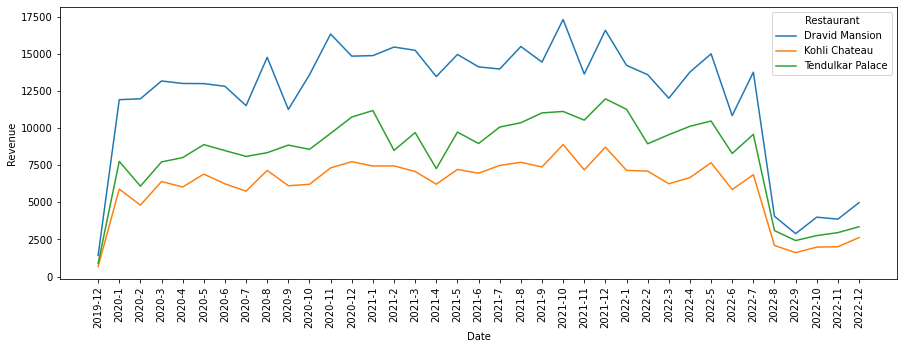

In [11]:
# Monthly revenue by each restaurant

plt.figure(figsize=(15,5))

sns.lineplot(x='Date', y='TotalPrice', hue='RestaurantName', data=monthly_rev)
plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.legend(title='Restaurant')

plt.show()

In [12]:
monthly_qty = df.groupby(['RestaurantName', 'Year', 'Month']).Quantity.agg(sum).reset_index()
monthly_qty.head(2)

,RestaurantName,Year,Month,Quantity
0,Dravid Mansion,2019,12,317
1,Dravid Mansion,2020,1,2582


In [13]:
df2 = monthly_rev.merge(monthly_qty['Quantity'], how='left', left_index=True, right_index=True)

In [14]:
df2['MeanRevenue'] = df2['TotalPrice']/df2['Quantity']
df2.head()

,RestaurantName,Year,Month,TotalPrice,Date,Quantity,MeanRevenue
0,Dravid Mansion,2019,12,1421.55,2019-12,317,4.484385
1,Dravid Mansion,2020,1,11924.70,2020-1,2582,4.618397
2,Dravid Mansion,2020,2,11985.05,2020-2,2567,4.668894
3,Dravid Mansion,2020,3,13187.10,2020-3,2868,4.598013
4,Dravid Mansion,2020,4,13018.35,2020-4,2828,4.603377


## Train/Test Split

In [15]:
rest_popped = df2.pop('RestaurantName')
date_popped = df2.pop('Date')

In [16]:
train = df2.query('Year <= 2022')
test = df2.query('Year == 2022')

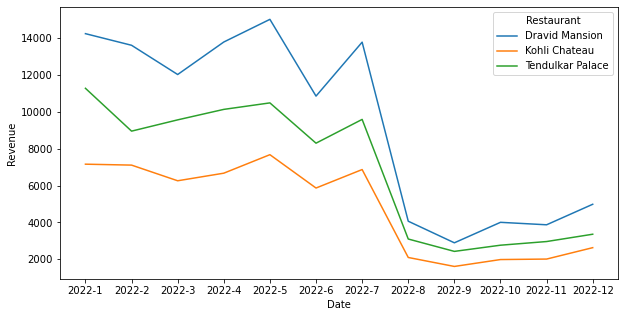

In [17]:
plt.figure(figsize=(10,5))

sns.lineplot(x=date_popped, y='TotalPrice', hue=rest_popped, data=test)
plt.ylabel('Revenue')
plt.legend(title='Restaurant')

plt.show()

## XGBoost Regressor Model

In [18]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [19]:
X_train = train.drop('TotalPrice', axis=1)
y_train = train['TotalPrice']

X_test = test.drop('TotalPrice', axis=1)
y_test = test['TotalPrice']

In [25]:
reg = xgb.XGBRegressor(n_estimators=1500, early_stopping_rounds=50, learning_rate=0.01)

model = reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=True)

[0]	validation_0-rmse:9631.47710	validation_1-rmse:8083.75465
[1]	validation_0-rmse:9539.56939	validation_1-rmse:8004.97186
[2]	validation_0-rmse:9448.53731	validation_1-rmse:7926.67793
[3]	validation_0-rmse:9358.41098	validation_1-rmse:7849.46259
[4]	validation_0-rmse:9269.13933	validation_1-rmse:7772.72377
[5]	validation_0-rmse:9180.73531	validation_1-rmse:7696.68793
[6]	validation_0-rmse:9093.16939	validation_1-rmse:7621.79541
[7]	validation_0-rmse:9006.49599	validation_1-rmse:7547.49255
[8]	validation_0-rmse:8920.62143	validation_1-rmse:7474.04506
[9]	validation_0-rmse:8835.59594	validation_1-rmse:7401.34571
[10]	validation_0-rmse:8751.34255	validation_1-rmse:7329.68791
[11]	validation_0-rmse:8667.98431	validation_1-rmse:7257.97145
[12]	validation_0-rmse:8585.36026	validation_1-rmse:7187.69689
[13]	validation_0-rmse:8503.61125	validation_1-rmse:7117.36277
[14]	validation_0-rmse:8422.58522	validation_1-rmse:7048.44488
[15]	validation_0-rmse:8342.34785	validation_1-rmse:6980.31940
[1

[130]	validation_0-rmse:2804.12767	validation_1-rmse:2265.36349
[131]	validation_0-rmse:2777.98741	validation_1-rmse:2242.75607
[132]	validation_0-rmse:2752.11331	validation_1-rmse:2220.90463
[133]	validation_0-rmse:2726.48199	validation_1-rmse:2198.74359
[134]	validation_0-rmse:2701.10774	validation_1-rmse:2176.78580
[135]	validation_0-rmse:2675.98112	validation_1-rmse:2156.04281
[136]	validation_0-rmse:2651.09577	validation_1-rmse:2135.51304
[137]	validation_0-rmse:2626.43656	validation_1-rmse:2115.45251
[138]	validation_0-rmse:2602.02504	validation_1-rmse:2095.30132
[139]	validation_0-rmse:2577.84815	validation_1-rmse:2075.34826
[140]	validation_0-rmse:2553.90422	validation_1-rmse:2055.65730
[141]	validation_0-rmse:2530.15708	validation_1-rmse:2035.74215
[142]	validation_0-rmse:2506.66716	validation_1-rmse:2016.42325
[143]	validation_0-rmse:2483.38830	validation_1-rmse:1997.41261
[144]	validation_0-rmse:2460.34773	validation_1-rmse:1978.46259
[145]	validation_0-rmse:2437.52107	valid

[259]	validation_0-rmse:867.42865	validation_1-rmse:662.75989
[260]	validation_0-rmse:859.88481	validation_1-rmse:656.58637
[261]	validation_0-rmse:852.41357	validation_1-rmse:650.56064
[262]	validation_0-rmse:845.01084	validation_1-rmse:644.57762
[263]	validation_0-rmse:837.63699	validation_1-rmse:638.64873
[264]	validation_0-rmse:830.37094	validation_1-rmse:632.76834
[265]	validation_0-rmse:823.17285	validation_1-rmse:626.95784
[266]	validation_0-rmse:816.02952	validation_1-rmse:621.29744
[267]	validation_0-rmse:808.92825	validation_1-rmse:615.64013
[268]	validation_0-rmse:801.92952	validation_1-rmse:609.98079
[269]	validation_0-rmse:794.99630	validation_1-rmse:604.38382
[270]	validation_0-rmse:788.11874	validation_1-rmse:598.93249
[271]	validation_0-rmse:781.28303	validation_1-rmse:593.55362
[272]	validation_0-rmse:774.54188	validation_1-rmse:588.10941
[273]	validation_0-rmse:767.86342	validation_1-rmse:582.72184
[274]	validation_0-rmse:761.24051	validation_1-rmse:577.50055
[275]	va

[392]	validation_0-rmse:289.56111	validation_1-rmse:209.32685
[393]	validation_0-rmse:287.38222	validation_1-rmse:207.74682
[394]	validation_0-rmse:285.22109	validation_1-rmse:206.13084
[395]	validation_0-rmse:283.07683	validation_1-rmse:204.58402
[396]	validation_0-rmse:280.95373	validation_1-rmse:203.06241
[397]	validation_0-rmse:278.85533	validation_1-rmse:201.62048
[398]	validation_0-rmse:276.76348	validation_1-rmse:200.06545
[399]	validation_0-rmse:274.69876	validation_1-rmse:198.59745
[400]	validation_0-rmse:272.64400	validation_1-rmse:197.05849
[401]	validation_0-rmse:270.61538	validation_1-rmse:195.61269
[402]	validation_0-rmse:268.61024	validation_1-rmse:194.23883
[403]	validation_0-rmse:266.61089	validation_1-rmse:192.74412
[404]	validation_0-rmse:264.63116	validation_1-rmse:191.28623
[405]	validation_0-rmse:262.67335	validation_1-rmse:189.88171
[406]	validation_0-rmse:260.73489	validation_1-rmse:188.50515
[407]	validation_0-rmse:258.80755	validation_1-rmse:187.18932
[408]	va

[525]	validation_0-rmse:117.11339	validation_1-rmse:85.70906
[526]	validation_0-rmse:116.40591	validation_1-rmse:85.20238
[527]	validation_0-rmse:115.69655	validation_1-rmse:84.69508
[528]	validation_0-rmse:115.00067	validation_1-rmse:84.20517
[529]	validation_0-rmse:114.29737	validation_1-rmse:83.75877
[530]	validation_0-rmse:113.59910	validation_1-rmse:83.30504
[531]	validation_0-rmse:112.90736	validation_1-rmse:82.86832
[532]	validation_0-rmse:112.22065	validation_1-rmse:82.42295
[533]	validation_0-rmse:111.53198	validation_1-rmse:81.97130
[534]	validation_0-rmse:110.85729	validation_1-rmse:81.54143
[535]	validation_0-rmse:110.18846	validation_1-rmse:81.11564
[536]	validation_0-rmse:109.52444	validation_1-rmse:80.69168
[537]	validation_0-rmse:108.86682	validation_1-rmse:80.27375
[538]	validation_0-rmse:108.20742	validation_1-rmse:79.85024
[539]	validation_0-rmse:107.56188	validation_1-rmse:79.44018
[540]	validation_0-rmse:106.92063	validation_1-rmse:79.03375
[541]	validation_0-rmse:

[662]	validation_0-rmse:54.69696	validation_1-rmse:42.53866
[663]	validation_0-rmse:54.41923	validation_1-rmse:42.35181
[664]	validation_0-rmse:54.15611	validation_1-rmse:42.16872
[665]	validation_0-rmse:53.88224	validation_1-rmse:41.98480
[666]	validation_0-rmse:53.60915	validation_1-rmse:41.79116
[667]	validation_0-rmse:53.35178	validation_1-rmse:41.61249
[668]	validation_0-rmse:53.08346	validation_1-rmse:41.43250
[669]	validation_0-rmse:52.81556	validation_1-rmse:41.24288
[670]	validation_0-rmse:52.56359	validation_1-rmse:41.06826
[671]	validation_0-rmse:52.30056	validation_1-rmse:40.89203
[672]	validation_0-rmse:52.04177	validation_1-rmse:40.71556
[673]	validation_0-rmse:51.78062	validation_1-rmse:40.53094
[674]	validation_0-rmse:51.53586	validation_1-rmse:40.36180
[675]	validation_0-rmse:51.29302	validation_1-rmse:40.19426
[676]	validation_0-rmse:51.03869	validation_1-rmse:40.02432
[677]	validation_0-rmse:50.78806	validation_1-rmse:39.83874
[678]	validation_0-rmse:50.55044	validat

[799]	validation_0-rmse:30.38913	validation_1-rmse:25.11505
[800]	validation_0-rmse:30.27630	validation_1-rmse:25.03364
[801]	validation_0-rmse:30.15922	validation_1-rmse:24.94601
[802]	validation_0-rmse:30.04898	validation_1-rmse:24.86627
[803]	validation_0-rmse:29.93841	validation_1-rmse:24.79503
[804]	validation_0-rmse:29.81792	validation_1-rmse:24.69992
[805]	validation_0-rmse:29.70879	validation_1-rmse:24.63112
[806]	validation_0-rmse:29.59514	validation_1-rmse:24.54629
[807]	validation_0-rmse:29.48684	validation_1-rmse:24.46870
[808]	validation_0-rmse:29.36925	validation_1-rmse:24.37601
[809]	validation_0-rmse:29.26241	validation_1-rmse:24.29894
[810]	validation_0-rmse:29.15724	validation_1-rmse:24.22321
[811]	validation_0-rmse:29.05194	validation_1-rmse:24.15774
[812]	validation_0-rmse:28.93689	validation_1-rmse:24.06712
[813]	validation_0-rmse:28.83270	validation_1-rmse:23.99333
[814]	validation_0-rmse:28.72448	validation_1-rmse:23.91300
[815]	validation_0-rmse:28.62257	validat

[936]	validation_0-rmse:19.42735	validation_1-rmse:17.05796
[937]	validation_0-rmse:19.37807	validation_1-rmse:17.02042
[938]	validation_0-rmse:19.33027	validation_1-rmse:16.98631
[939]	validation_0-rmse:19.27663	validation_1-rmse:16.94318
[940]	validation_0-rmse:19.22849	validation_1-rmse:16.91487
[941]	validation_0-rmse:19.18163	validation_1-rmse:16.88394
[942]	validation_0-rmse:19.12383	validation_1-rmse:16.84811
[943]	validation_0-rmse:19.07659	validation_1-rmse:16.82059
[944]	validation_0-rmse:19.03068	validation_1-rmse:16.78800
[945]	validation_0-rmse:18.97769	validation_1-rmse:16.74789
[946]	validation_0-rmse:18.92115	validation_1-rmse:16.71313
[947]	validation_0-rmse:18.87518	validation_1-rmse:16.68650
[948]	validation_0-rmse:18.83034	validation_1-rmse:16.65478
[949]	validation_0-rmse:18.77945	validation_1-rmse:16.61372
[950]	validation_0-rmse:18.73429	validation_1-rmse:16.58774
[951]	validation_0-rmse:18.68886	validation_1-rmse:16.55332
[952]	validation_0-rmse:18.64517	validat

[1072]	validation_0-rmse:14.22519	validation_1-rmse:13.29211
[1073]	validation_0-rmse:14.18855	validation_1-rmse:13.26967
[1074]	validation_0-rmse:14.16534	validation_1-rmse:13.25710
[1075]	validation_0-rmse:14.14835	validation_1-rmse:13.24301
[1076]	validation_0-rmse:14.12544	validation_1-rmse:13.23067
[1077]	validation_0-rmse:14.08950	validation_1-rmse:13.20820
[1078]	validation_0-rmse:14.07235	validation_1-rmse:13.18534
[1079]	validation_0-rmse:14.05531	validation_1-rmse:13.16268
[1080]	validation_0-rmse:14.03295	validation_1-rmse:13.15066
[1081]	validation_0-rmse:13.99762	validation_1-rmse:13.13603
[1082]	validation_0-rmse:13.94956	validation_1-rmse:13.09211
[1083]	validation_0-rmse:13.90209	validation_1-rmse:13.04874
[1084]	validation_0-rmse:13.86713	validation_1-rmse:13.02694
[1085]	validation_0-rmse:13.85101	validation_1-rmse:13.01351
[1086]	validation_0-rmse:13.83346	validation_1-rmse:12.99892
[1087]	validation_0-rmse:13.78670	validation_1-rmse:12.95625
[1088]	validation_0-rmse

[1207]	validation_0-rmse:10.16760	validation_1-rmse:9.62785
[1208]	validation_0-rmse:10.14558	validation_1-rmse:9.59841
[1209]	validation_0-rmse:10.11635	validation_1-rmse:9.57194
[1210]	validation_0-rmse:10.09770	validation_1-rmse:9.55550
[1211]	validation_0-rmse:10.07841	validation_1-rmse:9.54302
[1212]	validation_0-rmse:10.05675	validation_1-rmse:9.51395
[1213]	validation_0-rmse:10.03537	validation_1-rmse:9.48520
[1214]	validation_0-rmse:10.01636	validation_1-rmse:9.47284
[1215]	validation_0-rmse:9.99521	validation_1-rmse:9.44442
[1216]	validation_0-rmse:9.97647	validation_1-rmse:9.43220
[1217]	validation_0-rmse:9.95558	validation_1-rmse:9.40406
[1218]	validation_0-rmse:9.93736	validation_1-rmse:9.38776
[1219]	validation_0-rmse:9.91889	validation_1-rmse:9.37568
[1220]	validation_0-rmse:9.89831	validation_1-rmse:9.34790
[1221]	validation_0-rmse:9.88011	validation_1-rmse:9.33603
[1222]	validation_0-rmse:9.85985	validation_1-rmse:9.30864
[1223]	validation_0-rmse:9.84194	validation_1-rm

[1346]	validation_0-rmse:7.95616	validation_1-rmse:7.39911
[1347]	validation_0-rmse:7.94377	validation_1-rmse:7.38817
[1348]	validation_0-rmse:7.93152	validation_1-rmse:7.37766
[1349]	validation_0-rmse:7.92306	validation_1-rmse:7.36283
[1350]	validation_0-rmse:7.91097	validation_1-rmse:7.35237
[1351]	validation_0-rmse:7.89899	validation_1-rmse:7.34178
[1352]	validation_0-rmse:7.89065	validation_1-rmse:7.32706
[1353]	validation_0-rmse:7.87884	validation_1-rmse:7.31689
[1354]	validation_0-rmse:7.86713	validation_1-rmse:7.30651
[1355]	validation_0-rmse:7.85556	validation_1-rmse:7.29620
[1356]	validation_0-rmse:7.84959	validation_1-rmse:7.28126
[1357]	validation_0-rmse:7.83463	validation_1-rmse:7.26717
[1358]	validation_0-rmse:7.81991	validation_1-rmse:7.25329
[1359]	validation_0-rmse:7.80534	validation_1-rmse:7.23958
[1360]	validation_0-rmse:7.79717	validation_1-rmse:7.22512
[1361]	validation_0-rmse:7.78280	validation_1-rmse:7.21036
[1362]	validation_0-rmse:7.76862	validation_1-rmse:7.197

[1485]	validation_0-rmse:6.07141	validation_1-rmse:5.63184
[1486]	validation_0-rmse:6.05269	validation_1-rmse:5.62537
[1487]	validation_0-rmse:6.03915	validation_1-rmse:5.61591
[1488]	validation_0-rmse:6.02580	validation_1-rmse:5.60666
[1489]	validation_0-rmse:6.02026	validation_1-rmse:5.59630
[1490]	validation_0-rmse:5.99318	validation_1-rmse:5.57667
[1491]	validation_0-rmse:5.96676	validation_1-rmse:5.55580
[1492]	validation_0-rmse:5.94061	validation_1-rmse:5.53523
[1493]	validation_0-rmse:5.93677	validation_1-rmse:5.52901
[1494]	validation_0-rmse:5.91053	validation_1-rmse:5.51004
[1495]	validation_0-rmse:5.90517	validation_1-rmse:5.50011
[1496]	validation_0-rmse:5.87918	validation_1-rmse:5.48144
[1497]	validation_0-rmse:5.85381	validation_1-rmse:5.46160
[1498]	validation_0-rmse:5.85024	validation_1-rmse:5.45193
[1499]	validation_0-rmse:5.82472	validation_1-rmse:5.43368


In [21]:
test['Prediction'] = reg.predict(X_test)

In [22]:
df_pred = df2.merge(test['Prediction'], how='left', left_index=True, right_index=True)

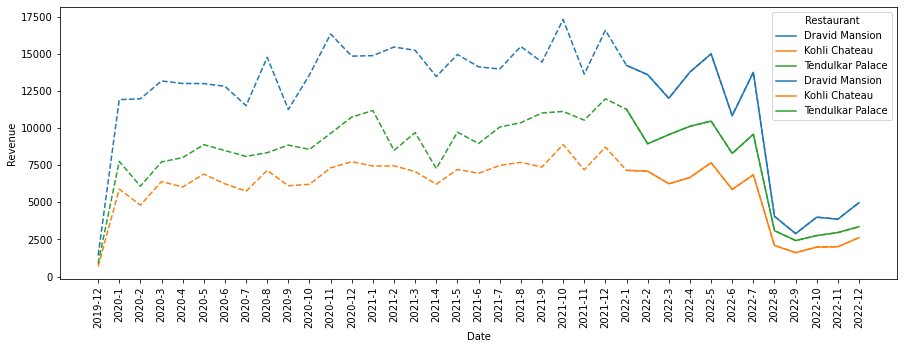

In [23]:
plt.figure(figsize=(15,5))

sns.lineplot(x=date_popped, y='TotalPrice', hue=rest_popped, data=df_pred, ls='--') # Actual number
sns.lineplot(x=date_popped, y='Prediction', hue=rest_popped, data=df_pred) # Prediction number

plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.legend(title='Restaurant')

plt.show()

In [24]:
df_pred.query('Year == 2022') # Prediction result

,Year,Month,TotalPrice,Quantity,MeanRevenue,Prediction
25,2022,1,14240.00,3053,4.664265,14234.482422
26,2022,2,13609.75,2974,4.576244,13614.017578
27,2022,3,12023.25,2601,4.622549,12015.092773
28,2022,4,13786.60,2913,4.732784,13789.234375
29,2022,5,15016.35,3346,4.487851,15016.240234
30,2022,6,10852.10,2246,4.831745,10845.082031
31,2022,7,13778.30,2762,4.988523,13773.257812
32,2022,8,4063.15,932,4.359603,4056.043457
33,2022,9,2891.85,622,4.649277,2892.709473
34,2022,10,4003.20,875,4.575086,4000.796387
